# 머신러닝 모델 비교

- 분류 알고리즘 비교
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

모듈 불러오기
--

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [53]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 

## 데이터 읽기 (포도주 품질)

In [4]:
wine = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/wine.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [5]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 데이터 탐색과 전처리
- 레이블 만들기

In [6]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 6.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups) 
wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [8]:
X = wine.drop(['quality', 'qual'], axis = 1) 
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


In [9]:
y = wine['qual'] 
y[:3]

0    0
1    0
2    0
Name: qual, dtype: category
Categories (2, int64): [0 < 1]

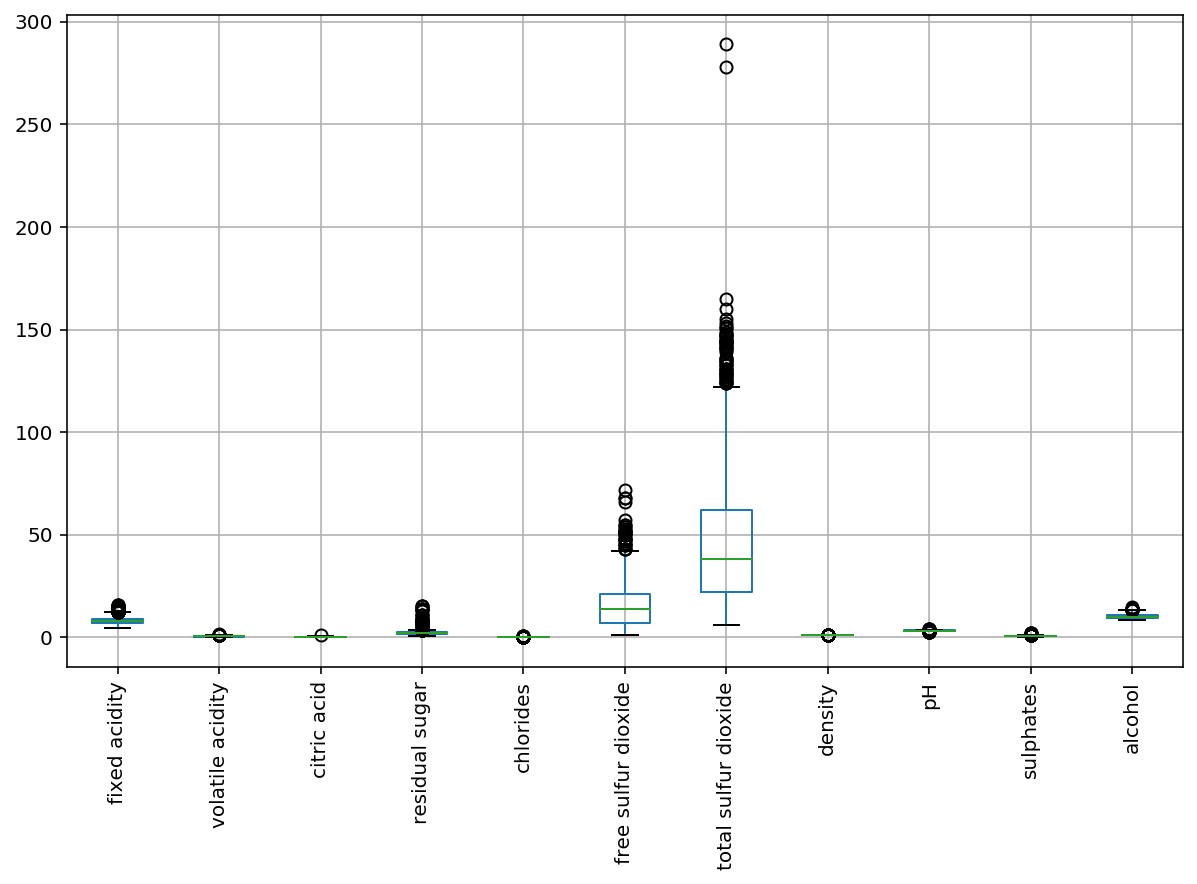

In [13]:
plt.figure(figsize=(10,6))
X.boxplot()
_=plt.xticks(rotation=90)

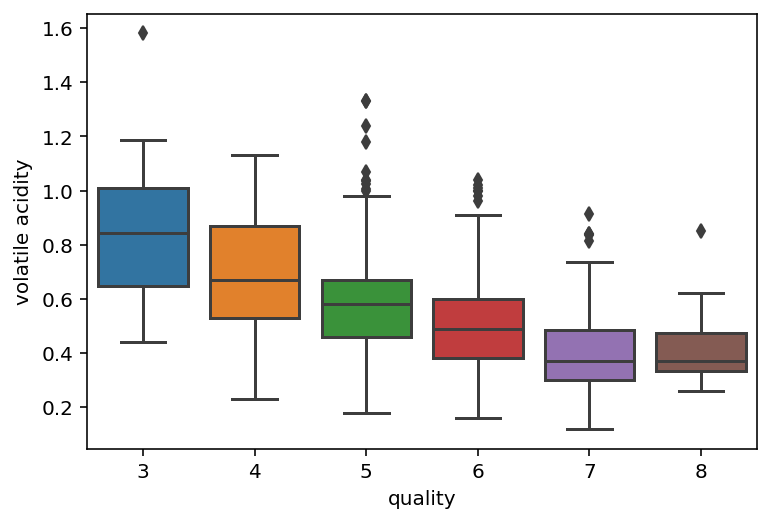

In [16]:
sns.boxplot(wine.quality, wine["volatile acidity"])

In [26]:
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

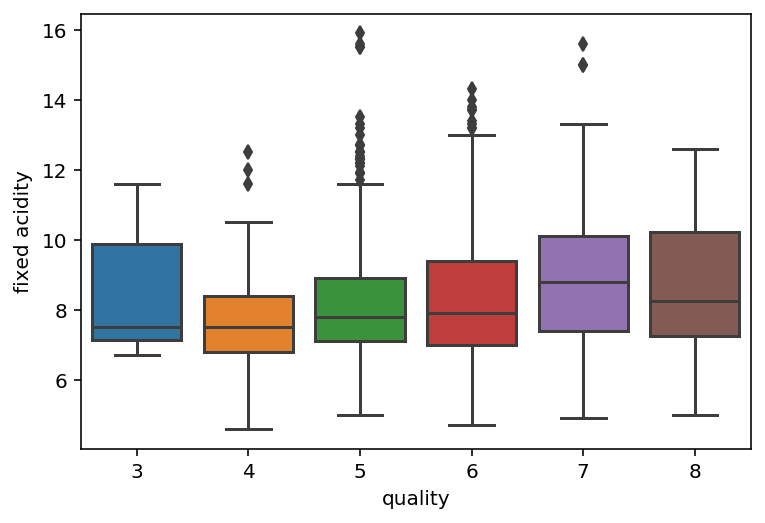

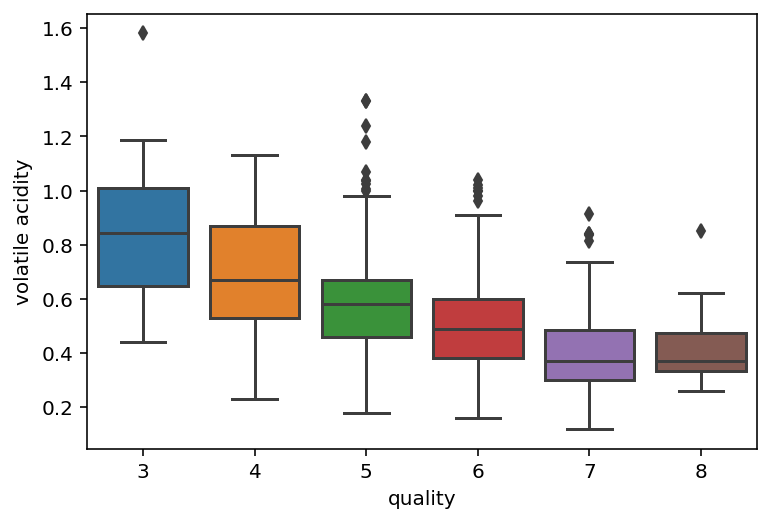

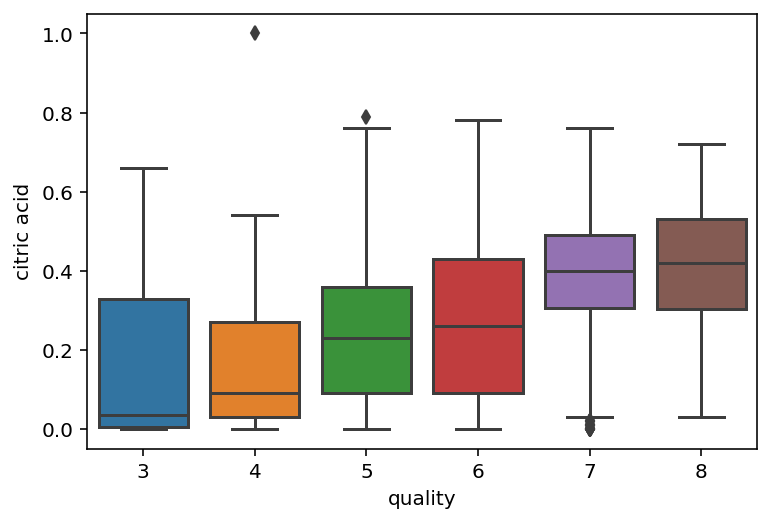

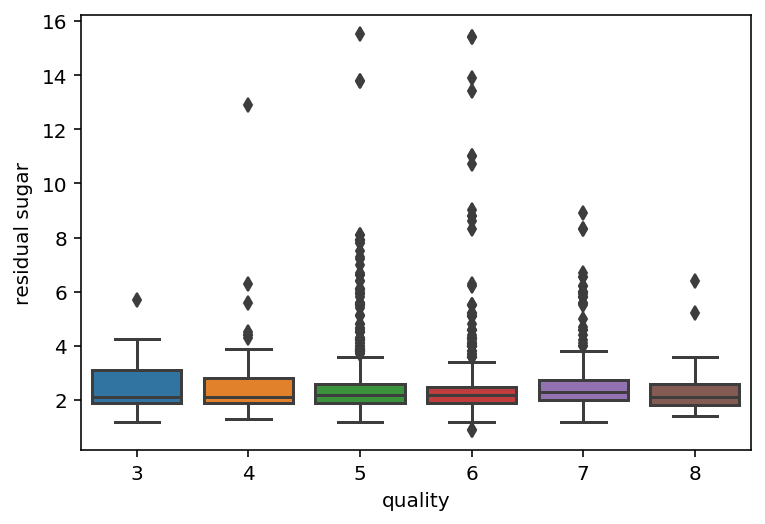

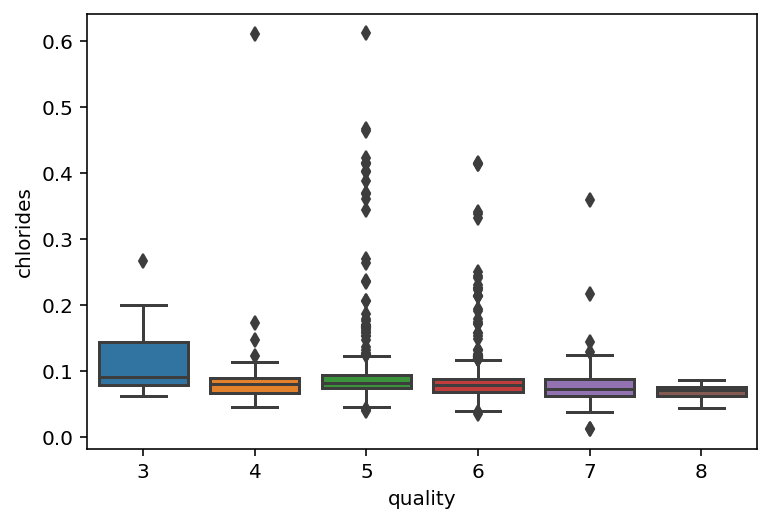

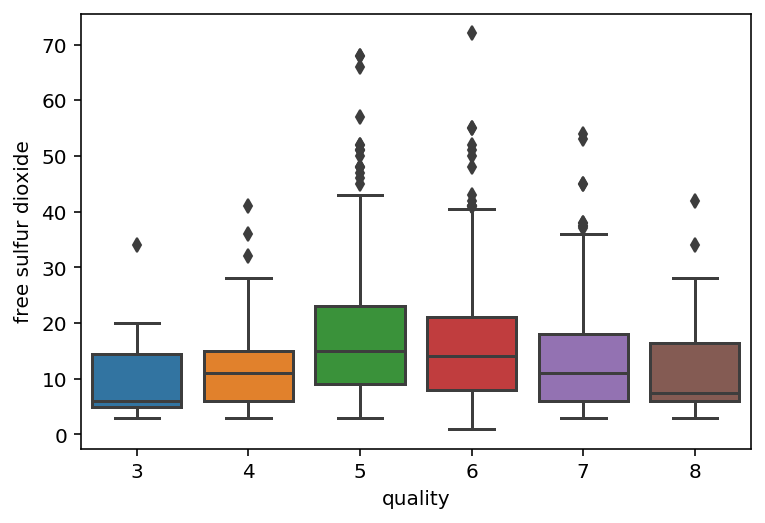

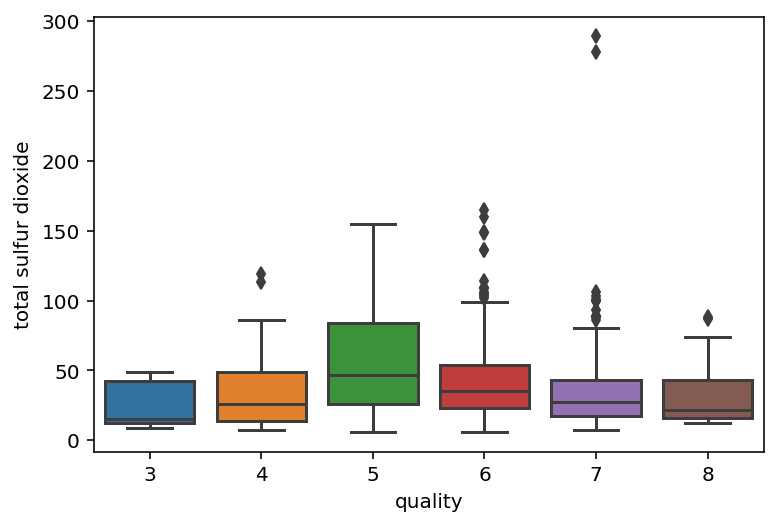

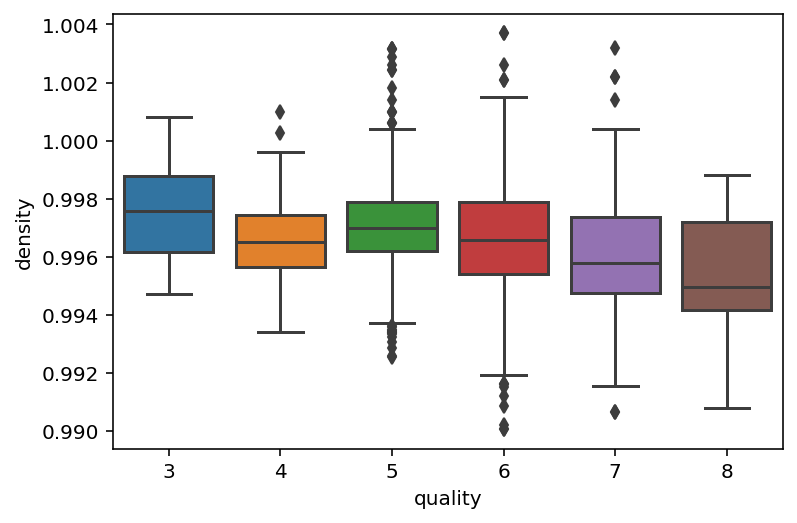

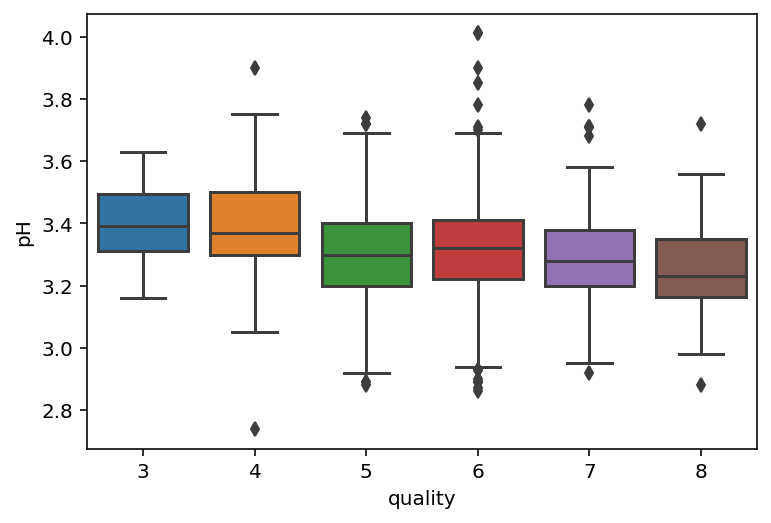

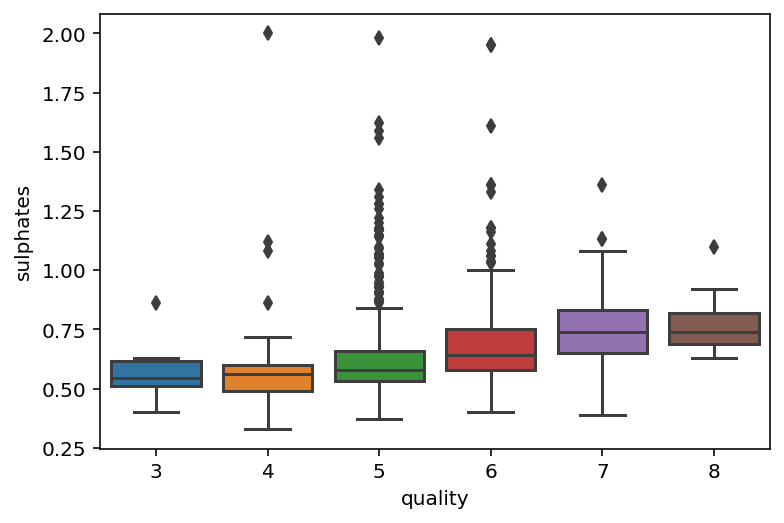

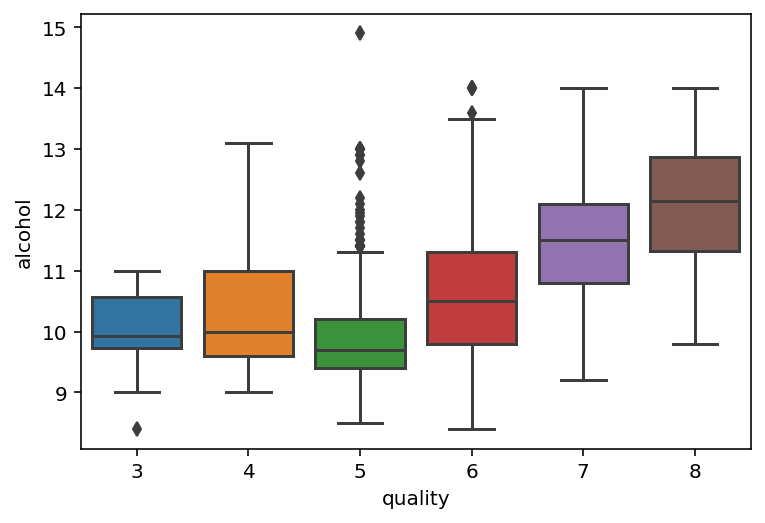

In [27]:
for col in cols:
    sns.boxplot(wine.quality, wine[col])
    plt.show()

표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [29]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [30]:
X[:3]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711]])

In [31]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, y_train.shape

((1199, 11), (1199,))

## 선형 모델

In [52]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

0.8525

In [42]:
cv = KFold(10)
cross_val_score(sgd, X, y, cv=cv).mean().round(4)

0.8493

결정 트리 (Decesion Tree)
--

In [73]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.885

In [91]:
cross_val_score(clf, X, y, cv=cv).mean().round(4)

0.8268

## 랜덤 포래스트 (Random Forest Classifier)

In [93]:
rfc = RandomForestClassifier(n_estimators=100) 
cross_val_score(rfc, X, y, cv=cv).mean().round(4)

0.8843

## Support Vector Classifier (SVC)

In [94]:
svc = SVC()
cross_val_score(rfc, X, y, cv=cv).mean().round(4)

0.8787

Logistic Regression
--

In [95]:
log = LogisticRegression()
cross_val_score(log, X, y, cv=cv).mean().round(4)

0.8749

#  혼돈 매트릭스 (confusion_matrix)

In [96]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[330,  10],
       [ 49,  11]])

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       340
           1       0.52      0.18      0.27        60

    accuracy                           0.85       400
   macro avg       0.70      0.58      0.59       400
weighted avg       0.82      0.85      0.82       400



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

# 랭킹 평가
- Score (맞다고 생각하는 점수)

In [100]:
y_score = sgd.decision_function(X_test)
y_score[:10]

array([-1.58434182, -4.24564287, -9.10973061, -3.84061669, -3.8825627 ,
       -7.13963836, -0.57082517, -6.30915422, -0.11771638, -4.91355308])

In [106]:
result = pd.DataFrame({'score':y_score, 'predict':y_pred, 'real': y_test, 
                       'correct': y_pred == y_test})
result[:20]

,score,predict,real,correct
1429,-1.584342,0,0,True
260,-4.245643,0,0,True
916,-9.109731,0,0,True
1141,-3.840617,0,0,True
1574,-3.882563,0,0,True
82,-7.139638,0,0,True
1038,-0.570825,0,1,False
641,-6.309154,0,0,True
56,-0.117716,0,0,True
1073,-4.913553,0,0,True


## ROC

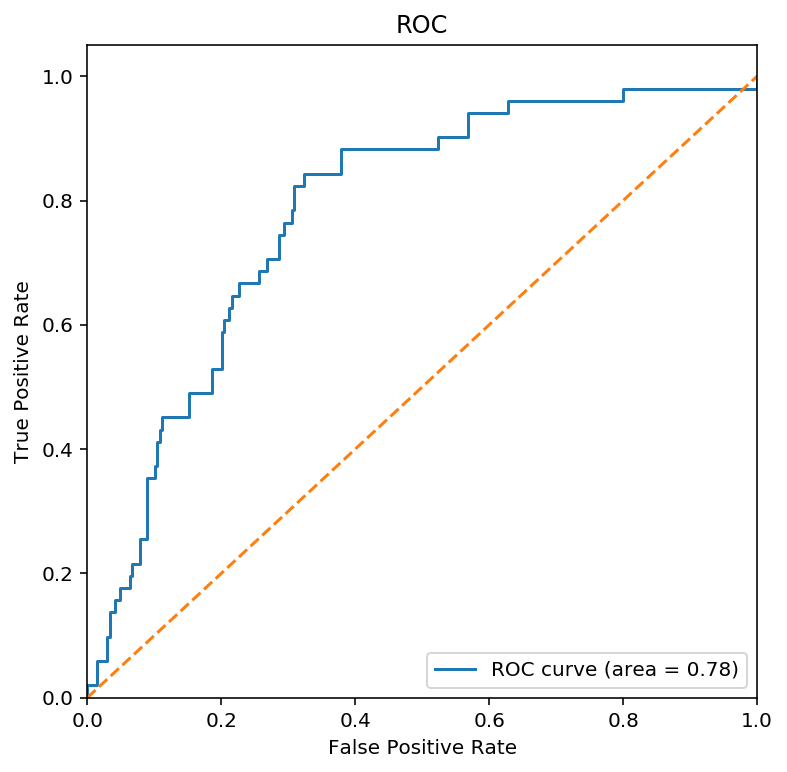

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

## 랜덤 포레스트
- 선형분류기의 성능은 위에 있음
- 랜덤포레스트를 사용한 경우의 성능 ROC, AUC 그린다 
 - 힌트: score = predict_proba(..)  --> (0일 확률, "1일 확율")

In [44]:
score_ref = rfc.predict_proba(X_test)[:,1]

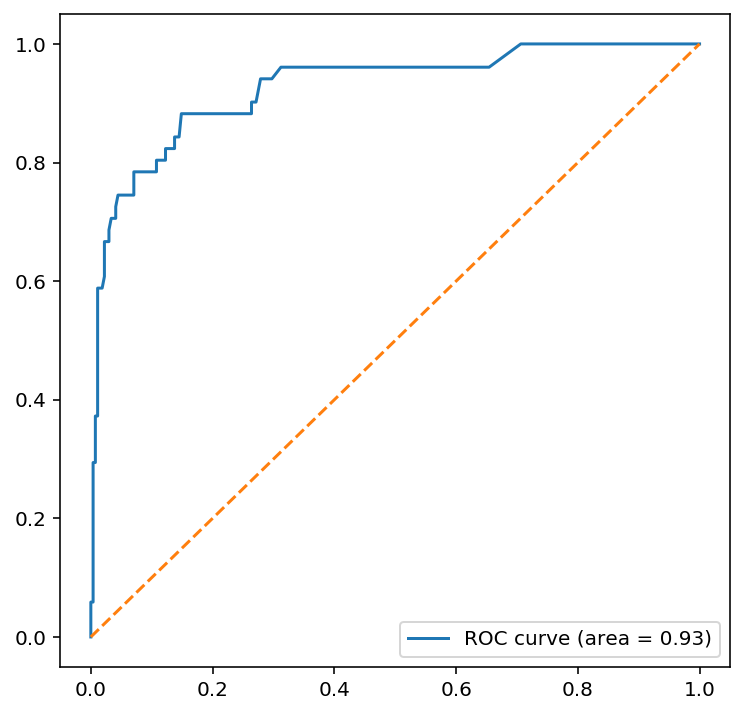

In [51]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, score_rfc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc="lower right")